# Motion by Curvature PDE in 3D Cartesian Grids

In this notebook, we are interested in solving the motion by curvature PDE. Consider a unit square domain $\Omega$ in 3D which is discretized as regular Cartesian grids. Let $u:\Omega\rightarrow \mathbb{R}$ be a function that satisfies the PDE
$$ |\nabla u(x)| \kappa(x) = f(x) $$
where $\kappa(x)$ is a curvature function defined as 
$$ \kappa(x) = - \text{div}\left( \frac{\nabla u(x)}{|\nabla u(x)|} \right)$$
We will solve this PDE using the monotone scheme proposed in the paper. The below is the outline of this notebook.

1. Importing library
2. Constructing 3d stencils
3. Constructing the right hand side function $f:\Omega\rightarrow \mathbb{R}$
4. Solve the PDE using the proposed monotone scheme
5. Plot the results

## Importing python libraries

In [1]:
import os
import numpy as np
import time
import tqdm
import matplotlib.pyplot as plt
from MonotoneScheme import Curv3DSolver
import plotly.graph_objects as go


# make folder if not exists
save_fig_path = 'figures'
if not os.path.exists(save_fig_path):
    os.makedirs(save_fig_path)
save_data_path = 'data'
if not os.path.exists(save_data_path):
    os.makedirs(save_data_path)

## Constructing 3D stencils

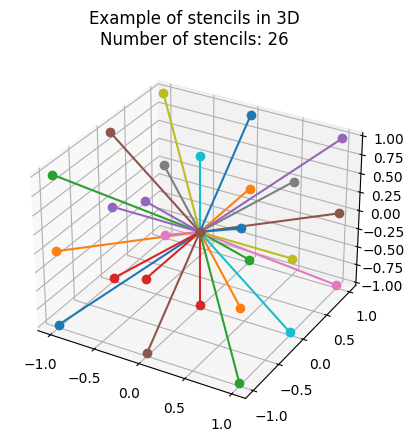

In [2]:
# 3D version

# Given a stencil_size, this function will return a numpy array of size [ __, 3 ]
# If stencil_size = 1 then it provides stencils ranging from -1 to 1
# If stencil_size = 2 then it provides stencils ranging from -2 to 2
def create_stencils_3d(stencil_size):
    stencils_tmp = []
    # add cases for i0 == 0
    for i0 in range(-stencil_size, stencil_size+1):
        for i1 in range(-stencil_size, stencil_size+1):
            for i2 in range(-stencil_size, stencil_size+1):
                if i0!=0 or i1!=0 or i2!=0:
                    stencils_tmp.append((i0,i1,i2, np.arctan2(i0,i1), np.arctan2(i0,i2), np.arctan2(i1,i2), i0*i0 + i1*i1 + i2*i2))

    stencils_tmp.sort(key=lambda x: x[6])
    stencils_tmp.sort(key=lambda x: x[5])
    stencils_tmp.sort(key=lambda x: x[4])
    stencils_tmp.sort(key=lambda x: x[3])

    stencils = []
    for i, it in enumerate(stencils_tmp):
        if i == 0:
            stencils.append(it[:3])
        else:
            if it[3] != stencils_tmp[i-1][3] or it[4] != stencils_tmp[i-1][4] or it[5] != stencils_tmp[i-1][5]:
                stencils.append(it[:3])

    del stencils_tmp
    return np.array(stencils)

# Let's get a numpy array that contains the list of stencils given the stencil size in 3D
stencil_size = 1
stencils = create_stencils_3d(stencil_size)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in stencils:
    ax.plot([0,i[0]], [0,i[1]], [0,i[2]], 'o-')
ax.set_title(f"Example of stencils in 3D\nNumber of stencils: {len(stencils)}")
plt.show()

## Constructing the right hand side function


# Note

The notebook uses `plotly` library to plot the 3d contour plot. If the error occurs, it is likely the version of `nbformat`. You can update the version by 
```
    pip install --upgrade nbformat
```


In [3]:
# create an empty f
n = 30
f = np.zeros((n,n,n))
u = np.ones((n,n,n))
# initializing f
xx = np.linspace(0.5/n,1-0.5/n,n)
X,Y,Z = np.meshgrid(xx,xx,xx)
X2,Y2 = np.meshgrid(xx,xx)

def f_ellipse():
    f = np.zeros((n,n,n))
    theta = -np.pi/3.0
    Xr = 0.5 + np.cos(theta)*(X-0.5) - np.sin(theta)*(Y-0.5)
    Yr = 0.5 + np.sin(theta)*(X-0.5) + np.cos(theta)*(Y-0.5)
    f[4*pow(Xr - 0.5,2) + pow(Yr-0.5,2) + pow(Z-0.5,2) < 0.5 ** 2] = 1
    return f

def twoballs():
    f = np.zeros((n,n,n))
    vals = []
    centers = [0.3, 0.7]
    for i in centers:
        vals.append((X-i)**2 + (Y-i)**2 + (Z-i)**2 <centers[0]**2)
    for val in vals:
        f[val] = 1
    return f

def eightballs():
    f = np.zeros((n,n,n))
    vals = []
    centers = [0.24, 0.76]
    for i in centers:
        for j in centers:
            for k in centers:
                vals.append((X-i)**2 + (Y-j)**2 + (Z-k)**2 <centers[0]**2)
    for val in vals:
        f[val] = 1
    return f

# f = eightballs()
# f = f_ellipse()
f = twoballs()
# f[(np.abs(X-0.5)<0.5) & (np.abs(Y-0.5)<0.5) & (np.abs(Z-0.5)<0.5)] = 1
# f[(np.abs(X-0.5)<0.3) & (np.abs(Y-0.5)<0.3) & (np.abs(Z-0.5)<0.3)] = 1

# f[((X-0.5)**2 + (Y-0.5)**2 + (Z-0.5)**2 <0.49**2) ] = 1


# returning contiguous arrays in memory
# u = np.ascontiguousarray(u, dtype=np.float64)  # solution
# f = np.ascontiguousarray(f, dtype=np.float64)  # the right hand side function

# plotting f
fig = go.Figure(data=go.Isosurface(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=f.flatten(),
    opacity=0.6,
    isomin=np.min(f),
    isomax=np.max(f),
    surface_count=10,
    caps=dict(x_show=False, y_show=False, z_show=False)
    ))
fig.show()

## Solve the PDE

Constructor finished. n:  30 stencil size:  1 number of stencils:  26


  0%|          | 0/500 [00:00<?, ?it/s]

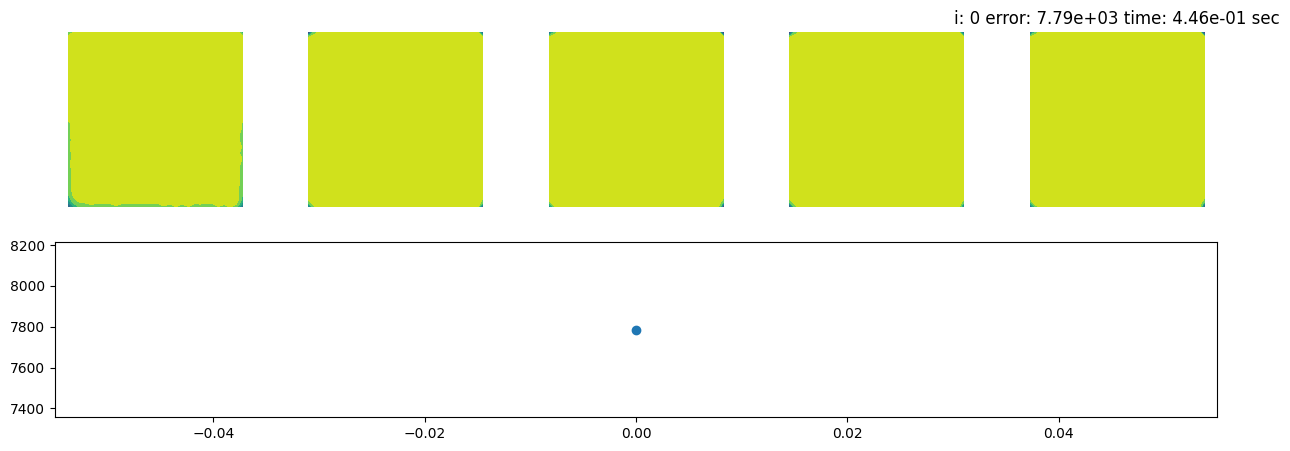

  2%|▏         | 10/500 [00:01<01:15,  6.50it/s]

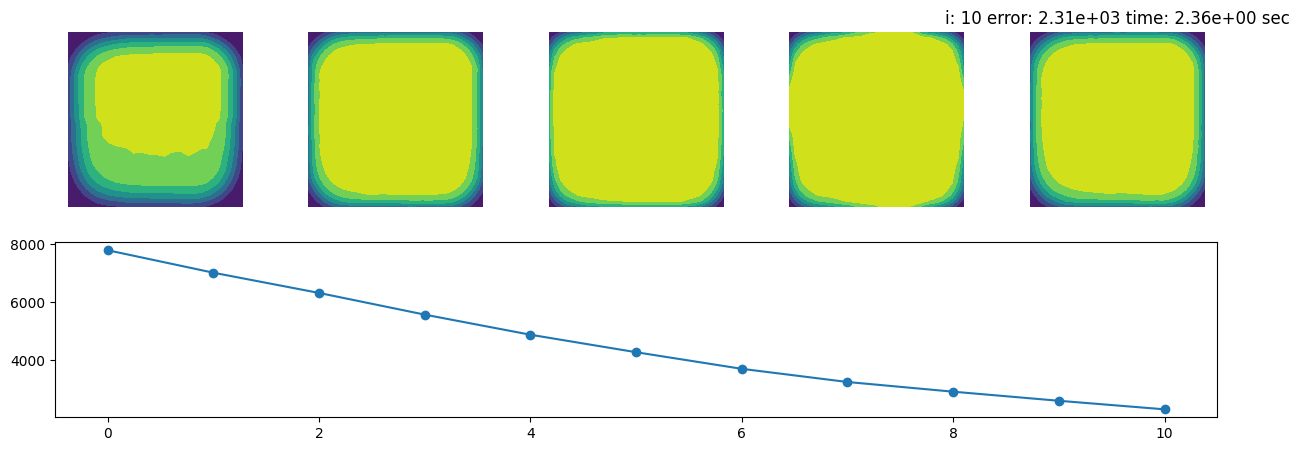

  4%|▍         | 20/500 [00:04<01:36,  4.97it/s]

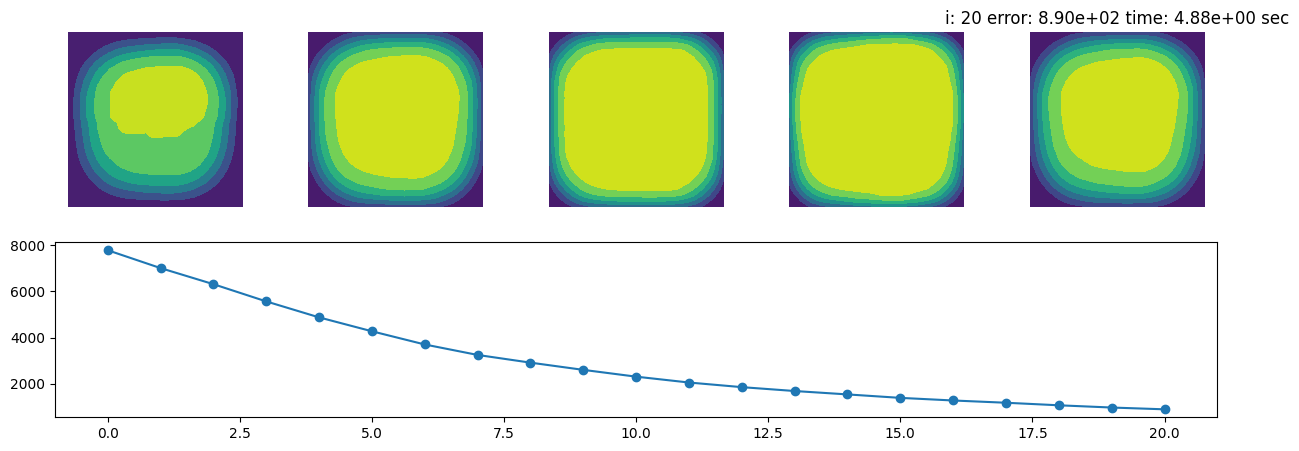

  6%|▌         | 30/500 [00:07<02:11,  3.57it/s]

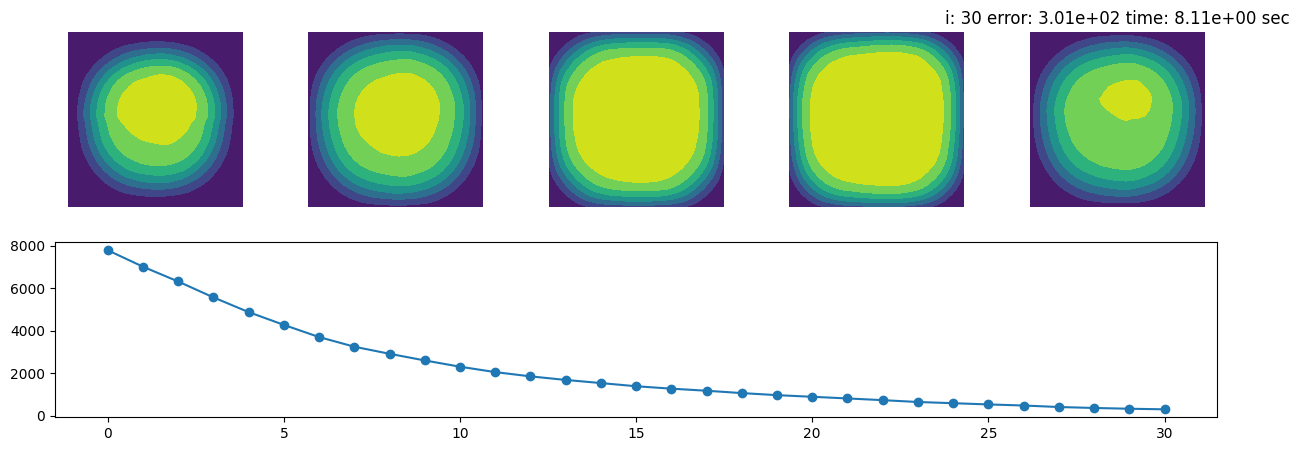

  8%|▊         | 40/500 [00:11<02:41,  2.85it/s]

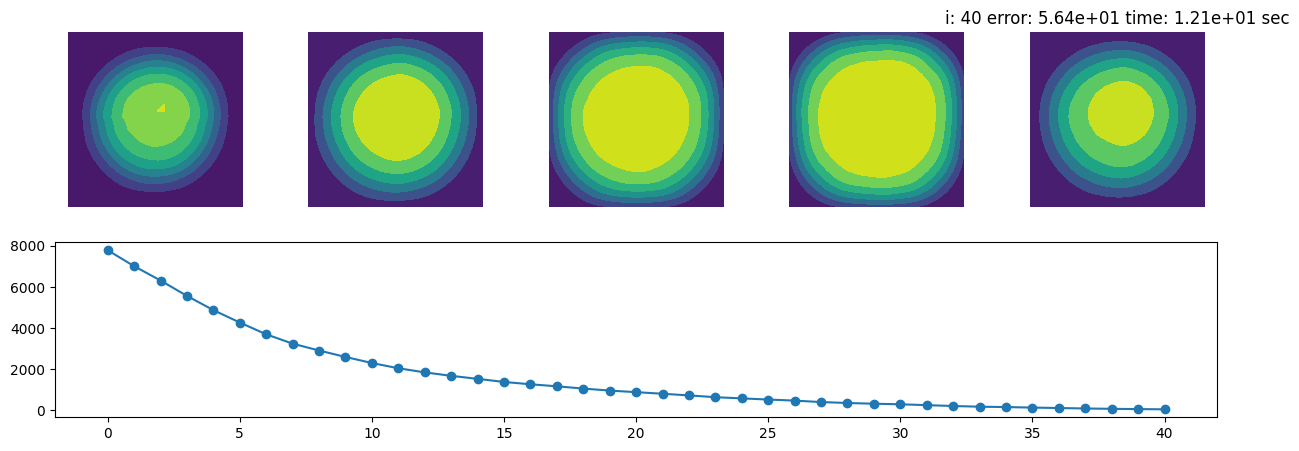

 10%|█         | 50/500 [00:15<02:57,  2.54it/s]

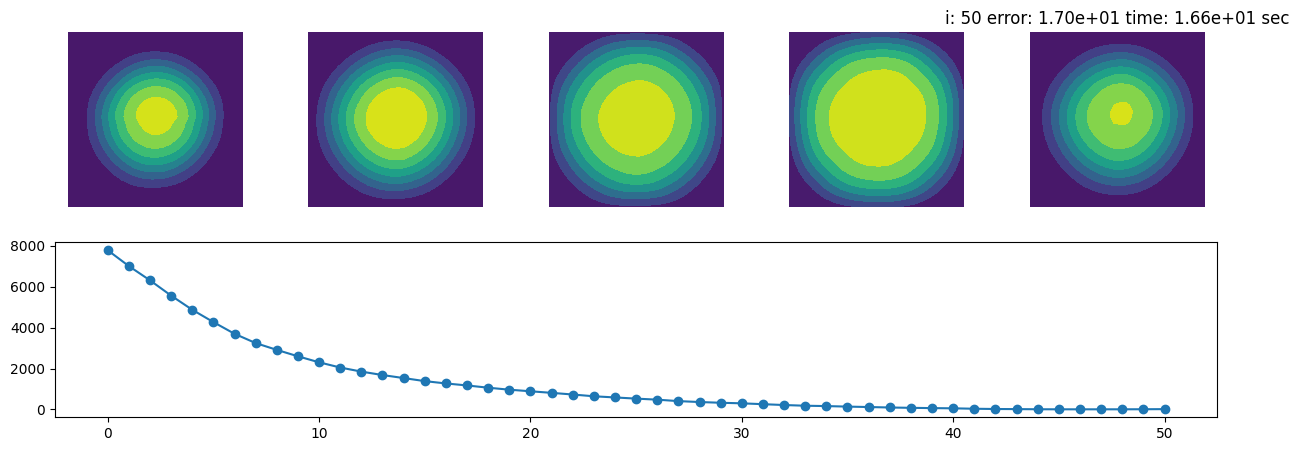

 12%|█▏        | 60/500 [00:20<03:31,  2.08it/s]

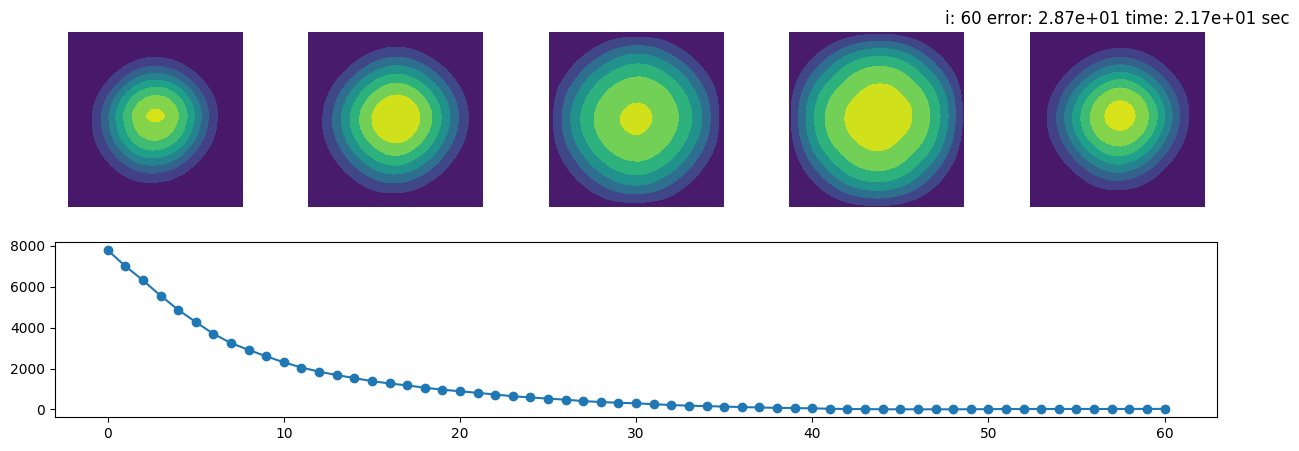

 14%|█▍        | 70/500 [00:26<03:53,  1.84it/s]

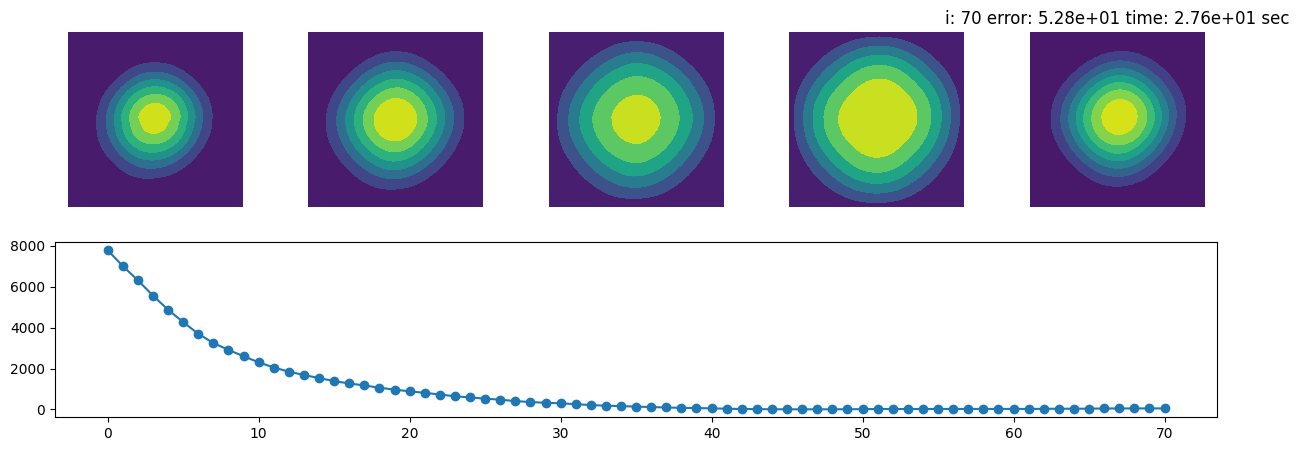

 16%|█▌        | 80/500 [00:32<03:56,  1.77it/s]

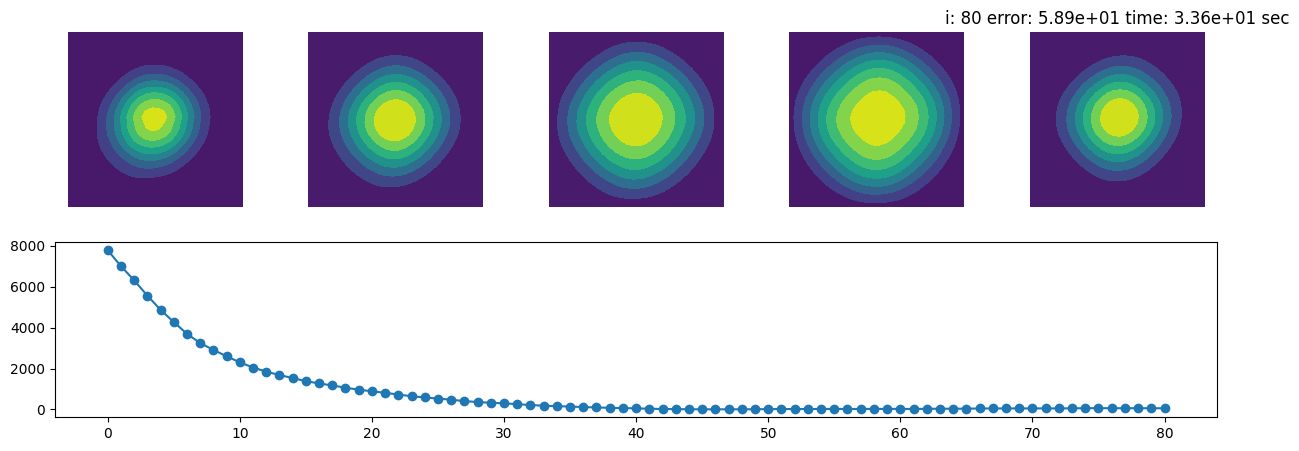

 18%|█▊        | 90/500 [00:39<04:14,  1.61it/s]

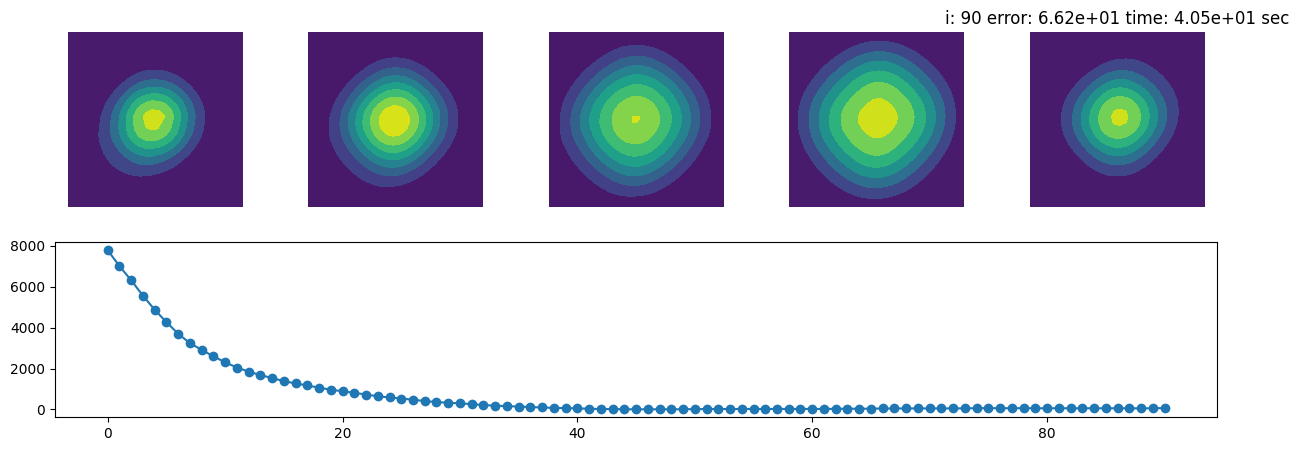

 20%|██        | 100/500 [00:46<04:31,  1.47it/s]

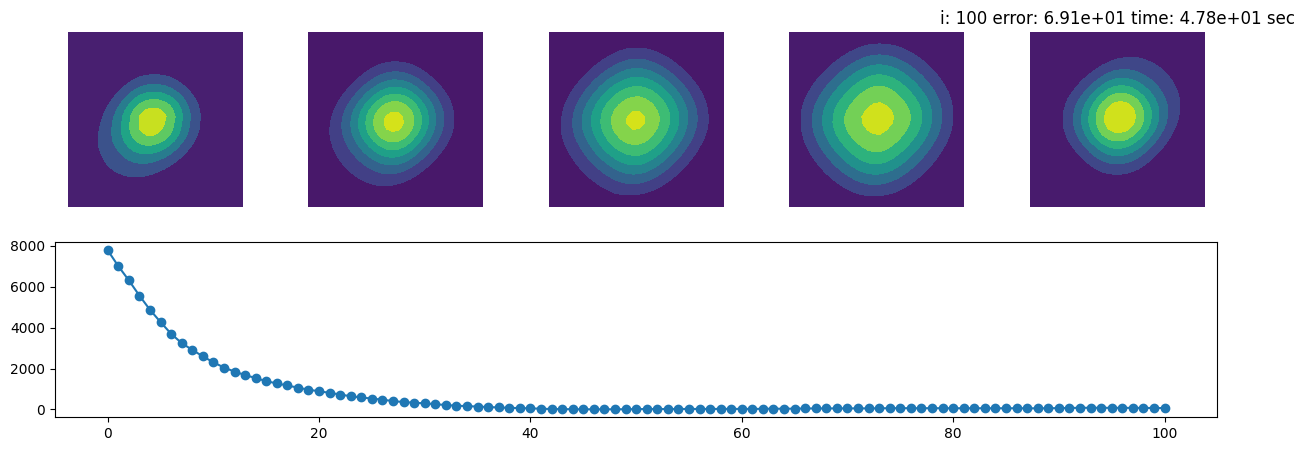

 22%|██▏       | 110/500 [00:54<04:34,  1.42it/s]

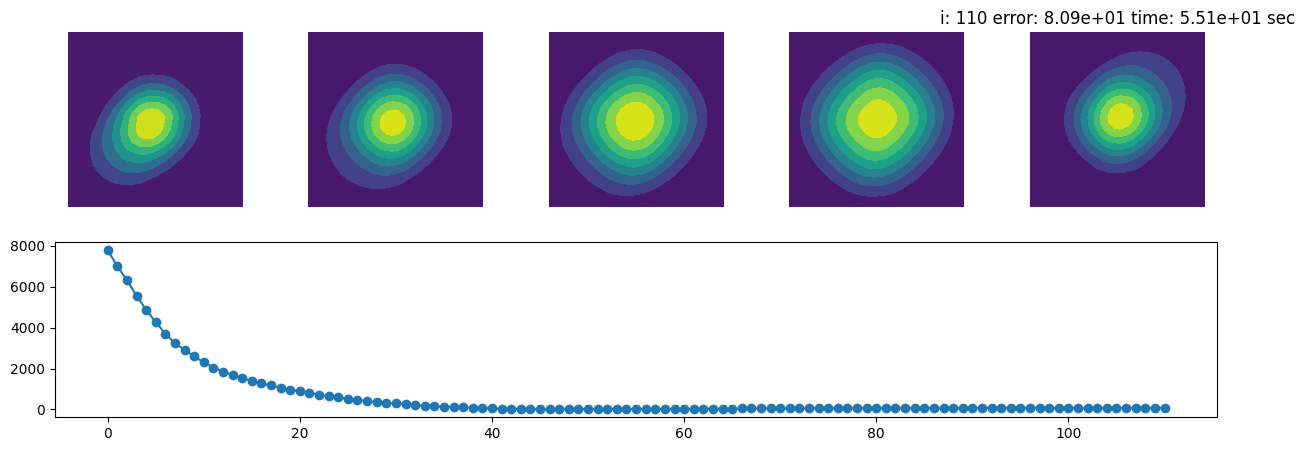

 24%|██▍       | 120/500 [01:02<04:34,  1.38it/s]

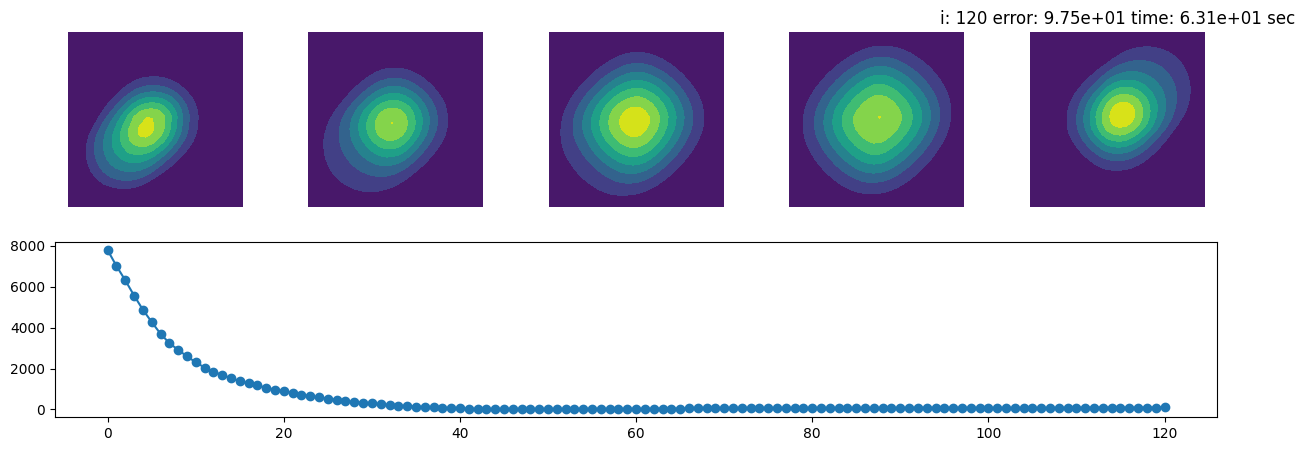

 26%|██▌       | 130/500 [01:10<04:50,  1.27it/s]

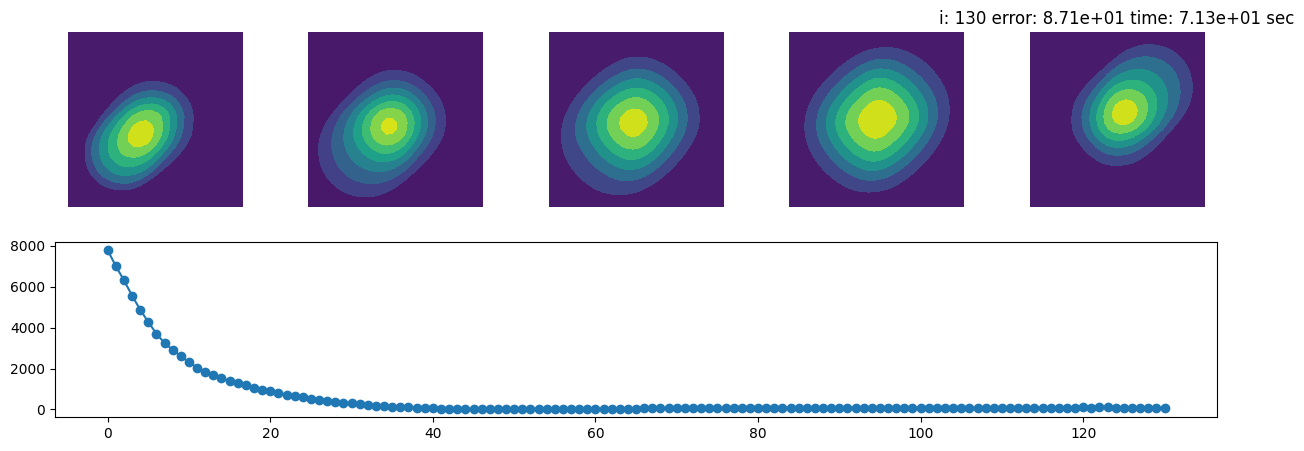

 28%|██▊       | 140/500 [01:18<04:40,  1.28it/s]

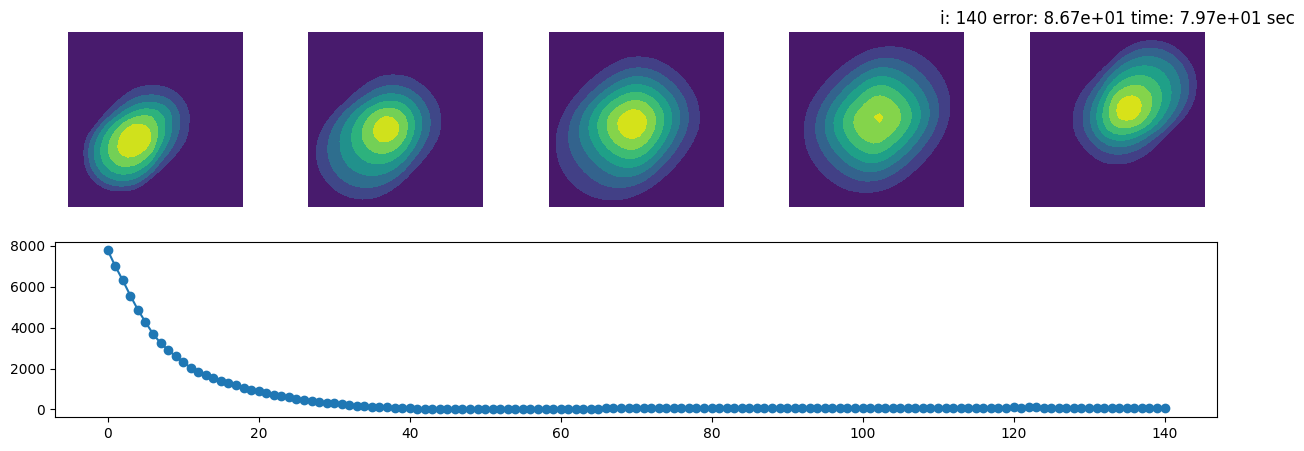

 30%|███       | 150/500 [01:27<04:48,  1.21it/s]

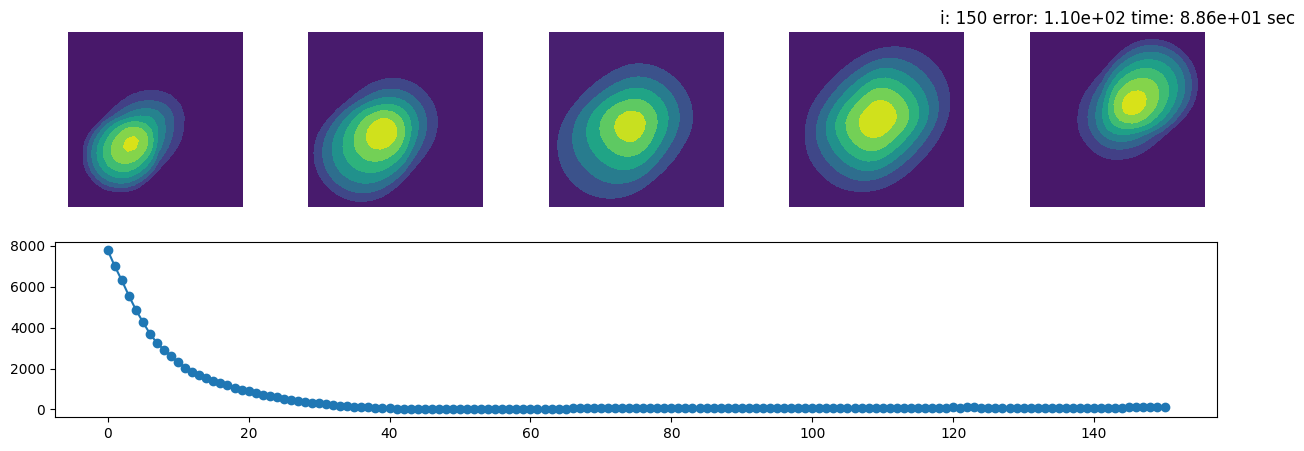

 32%|███▏      | 160/500 [01:36<04:41,  1.21it/s]

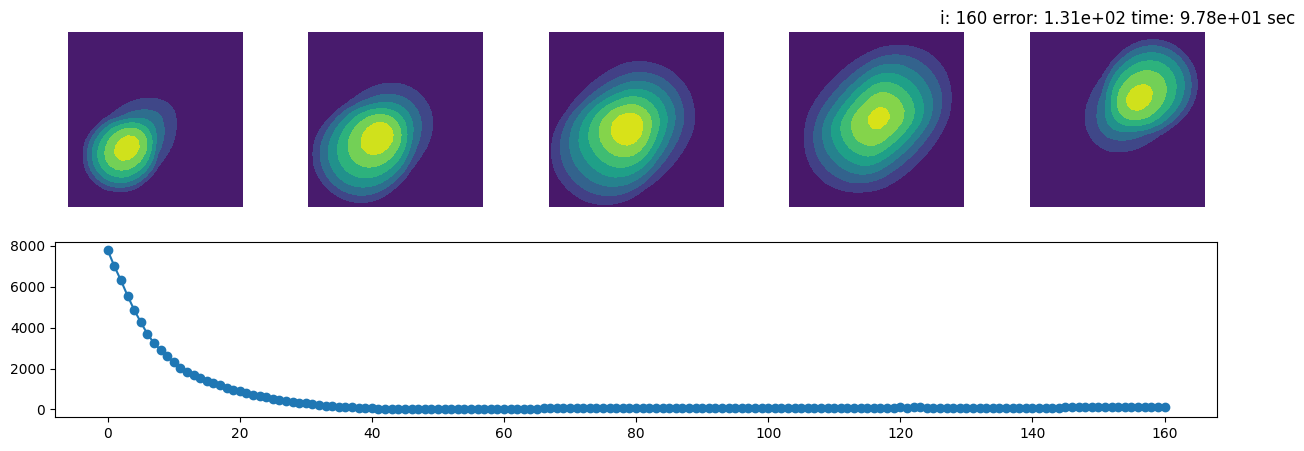

 34%|███▍      | 170/500 [01:46<05:00,  1.10it/s]

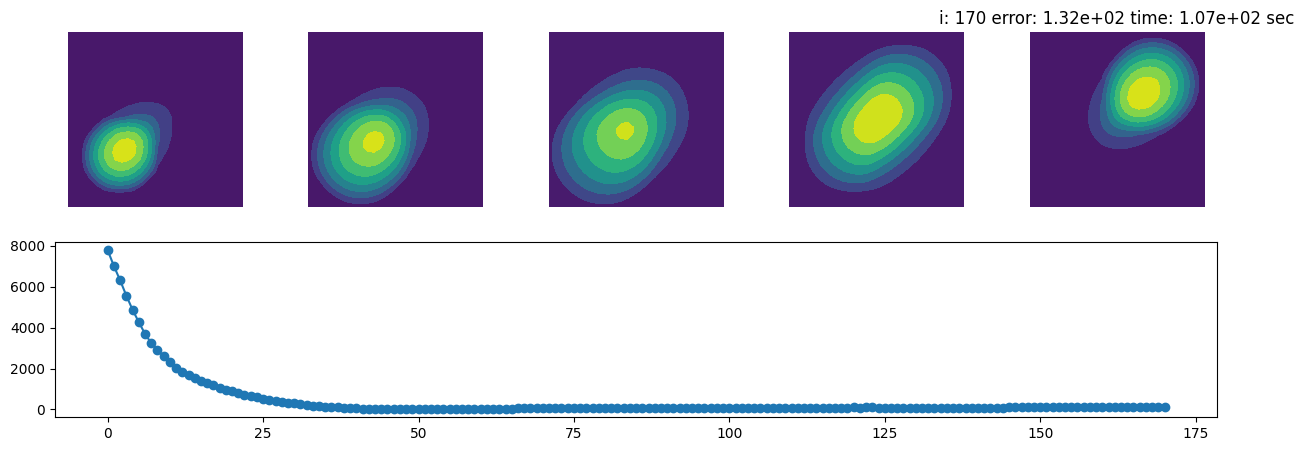

 36%|███▌      | 180/500 [01:55<04:57,  1.08it/s]

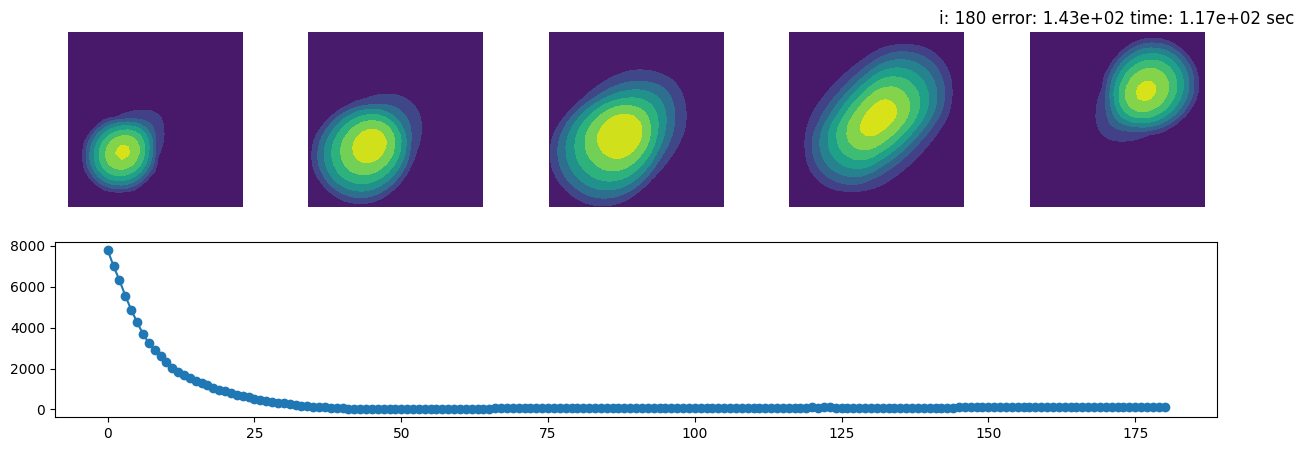

 38%|███▊      | 190/500 [02:06<04:54,  1.05it/s]

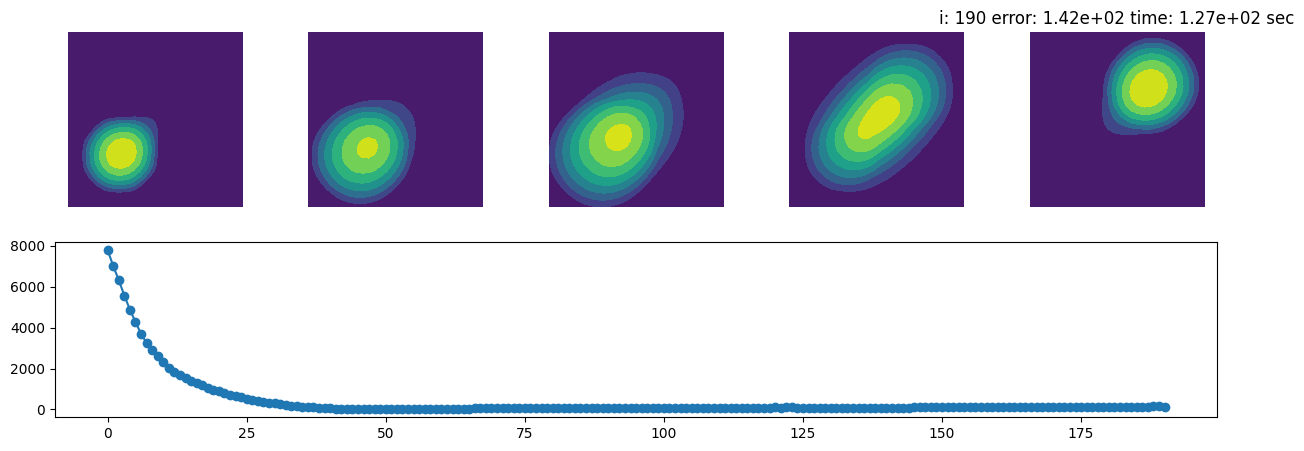

 40%|████      | 200/500 [02:15<04:35,  1.09it/s]

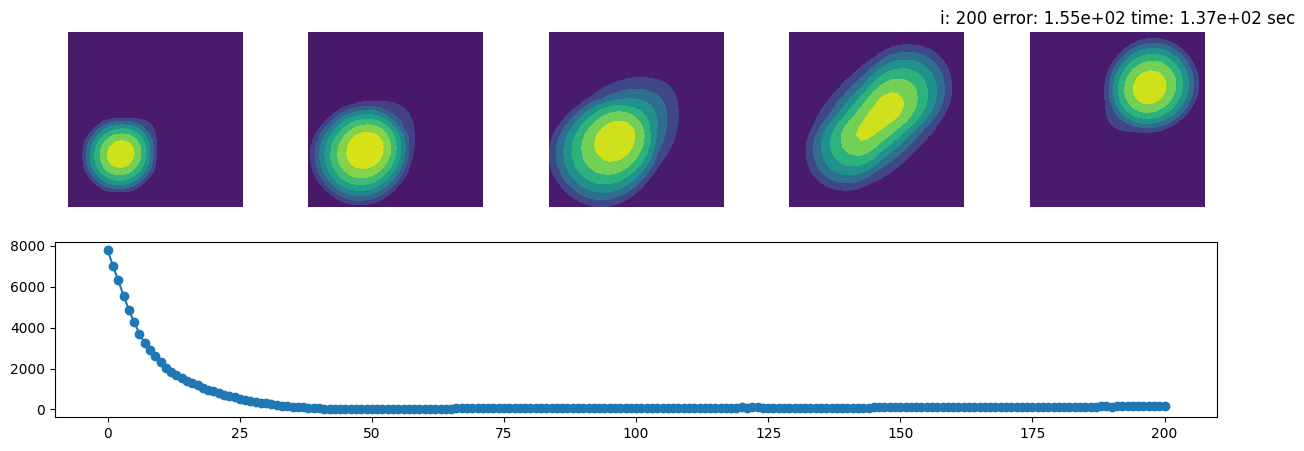

 42%|████▏     | 210/500 [02:25<04:21,  1.11it/s]

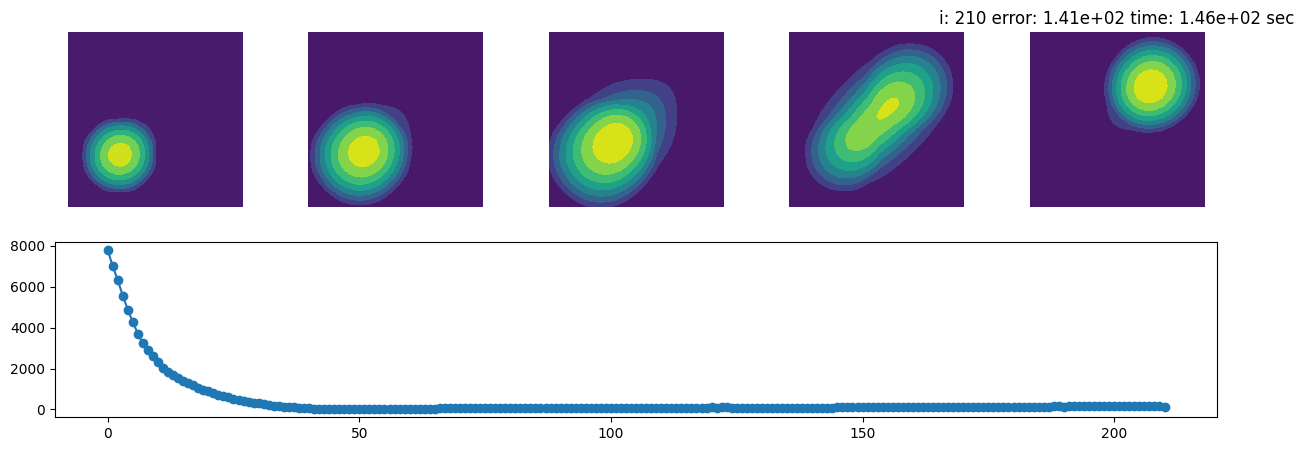

 44%|████▍     | 220/500 [02:35<04:17,  1.09it/s]

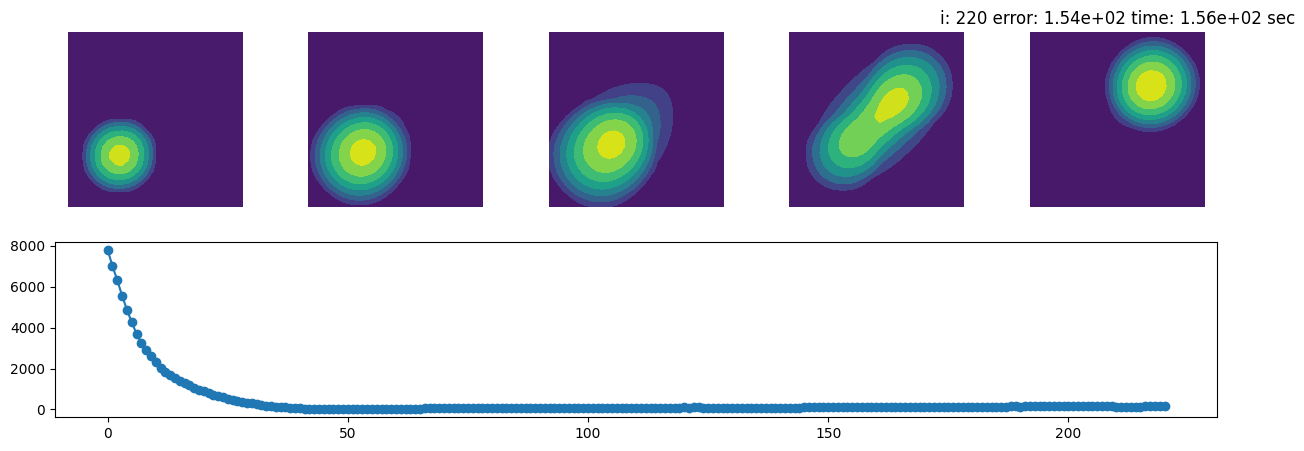

 46%|████▌     | 230/500 [02:45<04:12,  1.07it/s]

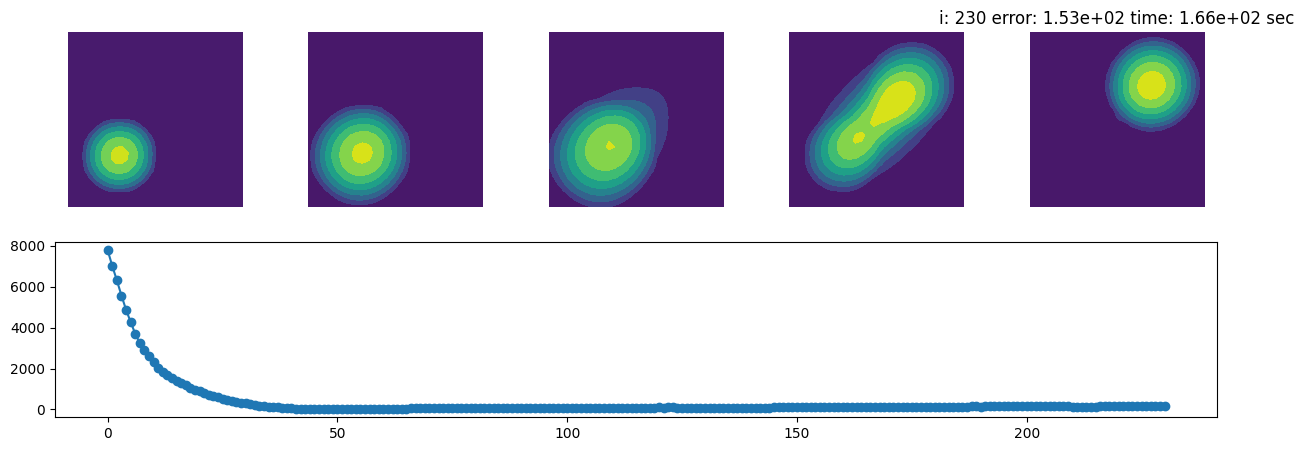

 48%|████▊     | 240/500 [02:55<04:03,  1.07it/s]

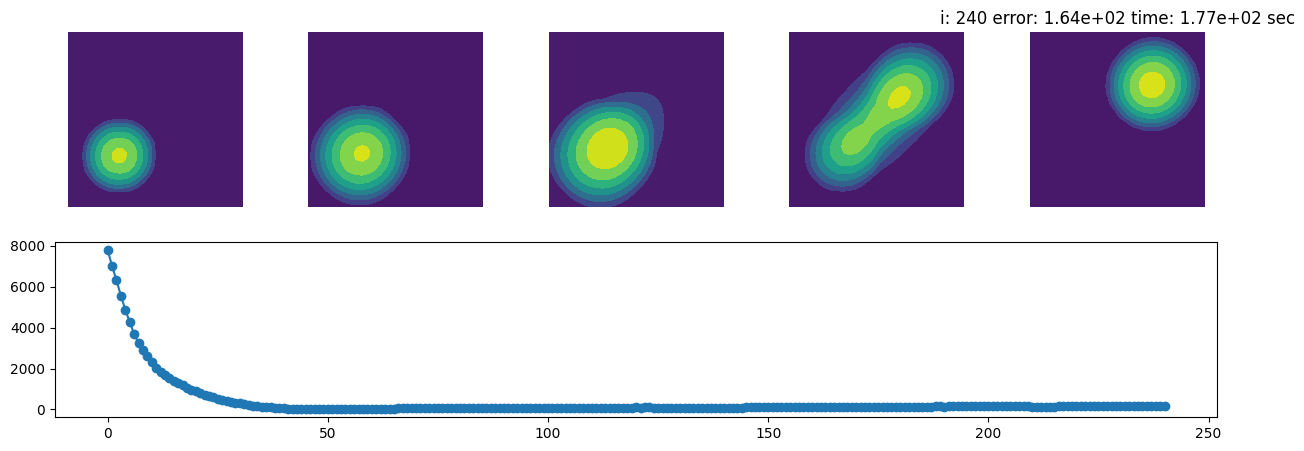

 49%|████▉     | 246/500 [03:02<03:08,  1.35it/s]


KeyboardInterrupt: 

In [4]:
# optimization parameters
max_iter = 500
tolerance= 1e-3

# initialize the HJ solver
solver = Curv3DSolver(f, stencils, stencil_size)

# Running the iterations
start_time = time.time()
error_array = []
offset_arr = [2,5, 10, 15, 25]

for i in tqdm.tqdm(range(max_iter)):
    error = solver.perform_one_iteration(u)
    error_array.append(error)
    # print(f"i: {i} error: {error:0.2e} time: {time.time() - start_time:0.2e} sec")
    # if error is less than tolerance stop the iteration
    if error < tolerance:
        break
    # save figures
    if i % 10 == 0:
        fig = plt.figure(figsize=(15,5))
        
        for ii in range(5):
            ax = fig.add_subplot(2,5,ii+1)
            ax.contourf(X2,Y2,u[offset_arr[ii],:,:])
            ax.axis('off')
            ax.set_aspect('equal')
        title_str = f"i: {i} error: {error:0.2e} time: {time.time() - start_time:0.2e} sec"
        plt.title(title_str)
        ax = fig.add_subplot(2,1,2)
        ax.plot(error_array,'o-')
        plt.savefig(f"{save_fig_path}/fig-{i//10}.png")
        plt.show()
    # save data
    if i % 100 == 0:
        np.save(f"{save_data_path}/data-{i//100}.npy",u)
    

## Plotting

In [5]:
# Load data
u = np.load(f"data/data-2.npy")

fig = go.Figure(data=go.Isosurface(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=u.flatten(),
    opacity=0.6,
    isomin=np.max(u),
    isomax=np.min(u),
    surface_count=10,
    caps=dict(x_show=False, y_show=False, z_show=False)
    ))
fig.show()